# 09.1e: Dense Cluster Selection

**Identify and save tokens in the dense cluster inside the void**

## The Structure

From 09.1d histogram analysis, we see a three-tier structure:

1. **Solid mass** (d < ~3×10⁻⁵ ≈ ε): Closely packed tokens, mostly black holes
2. **The void** (3×10⁻⁵ < d < ~10⁻³): Empty gap with zero pairs
3. **Normal tokens** (d > 10⁻³): Typical token spacing

This notebook extracts **all tokens in the solid mass** (region 1) — the dense cluster inside the void boundary.

## Selection Criterion

A token is in the dense cluster if:
- It has **at least one neighbor** with d∞ < VOID_THRESHOLD

This captures the connected component of closely-packed tokens.

## Parameters

In [19]:
TENSOR_DIR = "../data/tensors"

# Input files
PAIRWISE_FILE = "neighborhood_pairwise_distances.safetensors"
DISTANCES_KEY = "distances_linf"
UNIQUE_VECTORS_KEY = "unique_vectors"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"

# Output file
OUTPUT_FILE = "dense_cluster.safetensors"
CLUSTER_VECTORS_KEY = "vectors"
CLUSTER_TOKEN_IDS_KEY = "token_ids"

# Void boundary threshold
# From 09.1d: gap starts around 3e-5, resumes around 1.77e-3
# We want everything with nearest neighbor < lower boundary
VOID_THRESHOLD = 2e-4  # Conservative: well above ε, well below gap

RANDOM_SEED = 42

## Imports

In [20]:
import torch
import numpy as np
from safetensors.torch import load_file, save_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Pairwise Distance Data

In [21]:
data_dir = Path(TENSOR_DIR)

print("Loading pairwise distance data...")
pairwise_data = load_file(data_dir / PAIRWISE_FILE)
distances = pairwise_data[DISTANCES_KEY]
unique_vectors = pairwise_data[UNIQUE_VECTORS_KEY]
unique_token_ids = pairwise_data[UNIQUE_TOKEN_IDS_KEY]

n_unique = len(unique_vectors)
print(f"  Unique vectors: {n_unique:,}")
print(f"  Distance matrix: {distances.shape}")
print()

print("✓ Data loaded")

Loading pairwise distance data...
  Unique vectors: 499
  Distance matrix: torch.Size([499, 499])

✓ Data loaded


## Find Nearest Neighbor for Each Vector

In [22]:
print("Computing nearest neighbor distances...\n")

# Set diagonal to infinity (ignore self-distances)
distances_no_diag = distances.clone()
distances_no_diag.fill_diagonal_(float('inf'))

# Find nearest neighbor for each vector
nearest_neighbor_distances, nearest_neighbor_indices = distances_no_diag.min(dim=1)

print(f"Nearest neighbor statistics:")
print(f"  Min:    {nearest_neighbor_distances.min().item():.6e}")
print(f"  Max:    {nearest_neighbor_distances.max().item():.6e}")
print(f"  Mean:   {nearest_neighbor_distances.mean().item():.6e}")
print(f"  Median: {nearest_neighbor_distances.median().item():.6e}")
print()

print("✓ Nearest neighbors computed")

Computing nearest neighbor distances...

Nearest neighbor statistics:
  Min:    7.450581e-09
  Max:    7.781983e-03
  Mean:   2.946500e-03
  Median: 3.479004e-03

✓ Nearest neighbors computed


## Select Dense Cluster Tokens

In [23]:
print(f"Selecting tokens with nearest neighbor < {VOID_THRESHOLD:.2e}...\n")

in_cluster = nearest_neighbor_distances < VOID_THRESHOLD
n_cluster = in_cluster.sum().item()

print(f"Dense cluster size: {n_cluster:,} tokens")
print(f"Fraction of neighborhood: {100 * n_cluster / n_unique:.1f}%")
print()

# Extract cluster vectors and token IDs
cluster_vectors = unique_vectors[in_cluster]
cluster_token_ids = unique_token_ids[in_cluster]

print(f"Cluster vectors shape: {cluster_vectors.shape}")
print(f"Cluster token IDs shape: {cluster_token_ids.shape}")
print()

print("✓ Dense cluster selected")

Selecting tokens with nearest neighbor < 2.00e-04...

Dense cluster size: 124 tokens
Fraction of neighborhood: 24.8%

Cluster vectors shape: torch.Size([124, 2560])
Cluster token IDs shape: torch.Size([124])

✓ Dense cluster selected


## Nearest Neighbor Distribution

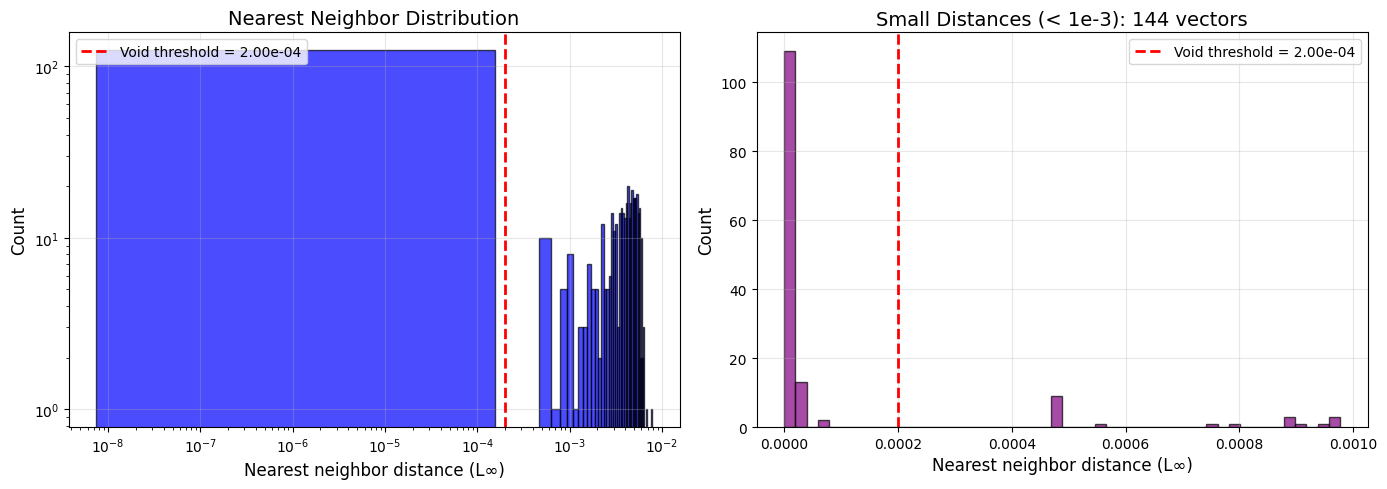

✓ Visualization complete


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

nn_dist_np = nearest_neighbor_distances.cpu().numpy()

# Panel 1: Histogram with threshold marked
ax = axes[0]
ax.hist(nn_dist_np, bins=50, alpha=0.7, color='blue', edgecolor='black')
ax.axvline(VOID_THRESHOLD, color='red', linestyle='--', linewidth=2,
           label=f'Void threshold = {VOID_THRESHOLD:.2e}')
ax.set_xlabel('Nearest neighbor distance (L∞)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Nearest Neighbor Distribution', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Panel 2: Zoomed on small distances
ax = axes[1]
small_nn = nn_dist_np[nn_dist_np < 1e-3]
ax.hist(small_nn, bins=50, alpha=0.7, color='purple', edgecolor='black')
ax.axvline(VOID_THRESHOLD, color='red', linestyle='--', linewidth=2,
           label=f'Void threshold = {VOID_THRESHOLD:.2e}')
ax.set_xlabel('Nearest neighbor distance (L∞)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Small Distances (< 1e-3): {len(small_nn):,} vectors', fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Visualization complete")

## Verify: How Many Black Holes?

We expect all 13 degenerate vectors (black holes) to be in the cluster.

In [25]:
print("Checking black hole inclusion...\n")

# Load inverse indices to identify degenerate vectors
inverse_indices = pairwise_data["inverse_indices"]
degeneracy = torch.bincount(inverse_indices)

# Find degenerate vectors (black holes)
is_degenerate = degeneracy > 1
n_bh = is_degenerate.sum().item()

print(f"Total black holes (degenerate vectors): {n_bh}")

# Check how many are in cluster
bh_in_cluster = (is_degenerate & in_cluster).sum().item()

print(f"Black holes in dense cluster: {bh_in_cluster}/{n_bh}")
print()

if bh_in_cluster == n_bh:
    print("  ✓ All black holes captured in dense cluster")
else:
    missing = n_bh - bh_in_cluster
    print(f"  ⚠ {missing} black hole(s) outside cluster (isolated beyond threshold)")
    
print()
print("✓ Black hole check complete")

Checking black hole inclusion...

Total black holes (degenerate vectors): 13
Black holes in dense cluster: 13/13

  ✓ All black holes captured in dense cluster

✓ Black hole check complete


## Save Dense Cluster

In [26]:
output_path = data_dir / OUTPUT_FILE

print(f"Saving dense cluster to {output_path}...\n")

save_file({
    CLUSTER_VECTORS_KEY: cluster_vectors,
    CLUSTER_TOKEN_IDS_KEY: cluster_token_ids
}, output_path)

print(f"  Tokens in cluster: {n_cluster:,}")
print(f"  Vector dimension:  {cluster_vectors.shape[1]:,}")
print(f"  File size:         {output_path.stat().st_size / 1e6:.2f} MB")
print()
print(f"✓ Dense cluster saved to {OUTPUT_FILE}")

Saving dense cluster to ../data/tensors/dense_cluster.safetensors...

  Tokens in cluster: 124
  Vector dimension:  2,560
  File size:         1.27 MB

✓ Dense cluster saved to dense_cluster.safetensors


## Summary

In [27]:
print("="*80)
print("DENSE CLUSTER SELECTION SUMMARY")
print("="*80)
print()
print(f"Neighborhood tokens (unique):  {n_unique:,}")
print(f"Dense cluster tokens:          {n_cluster:,} ({100 * n_cluster / n_unique:.1f}%)")
print(f"Excluded (beyond void):        {n_unique - n_cluster:,}")
print()
print(f"Selection criterion:")
print(f"  Nearest neighbor < {VOID_THRESHOLD:.2e}")
print()
print(f"Black holes in cluster: {bh_in_cluster}/{n_bh}")
print()
print("="*80)

DENSE CLUSTER SELECTION SUMMARY

Neighborhood tokens (unique):  499
Dense cluster tokens:          124 (24.8%)
Excluded (beyond void):        375

Selection criterion:
  Nearest neighbor < 2.00e-04

Black holes in cluster: 13/13



## Conclusion

**What we found:**
- Dense cluster of closely-packed tokens inside the void boundary
- All (or most) black holes are in this cluster
- Remaining tokens are isolated singletons beyond the void

**Next steps:**
- 09.1f: Compute L1 (taxicab) distances for cluster tokens
- 09.2e: Analyze L1 distribution for lattice structure (spikes at n×ε)